## Import Necessary Libraries

In [6]:
import os
import torch
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision import datasets ,models , transforms

## Directories and Hyperparameters

In [14]:
csv_file = ("/content/drive/MyDrive/Construction Equipment Activity/Feature Extraction/audio/data.csv")
imagedir = ("/content/drive/MyDrive/Construction Equipment Activity/Feature Extraction/audio/bulldozer_dump_truck")
# Let's define epoch numbers
EPOCHS = 10
BATCH_SIZE = 10

## Create custom Dataset Class

In [15]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.data.iloc[idx, 2:]
        label = torch.tensor(label.values.astype(np.float32))
        if self.transform:
            image = self.transform(image)
        return image, label

## Image Transformation

In [16]:
# Transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Create dataset object and print

In [17]:
fulldataset = CustomDataset(csv_file, imagedir, transform=transform)
print(fulldataset)

image, label=fulldataset[0]
print(image.shape, label.shape)

torch.Size([3, 28, 28]) torch.Size([2])


## Split the full datset for train and test

In [18]:
# Train Test Split random
train_size = int(len(fulldataset) * 0.8)
test_size = len(fulldataset) - train_size
traindataset ,testdataset  = random_split( fulldataset , [train_size  ,test_size])

print(train_size)
print(test_size)
print(traindataset)
print(testdataset)

8
2


## Train Test dataloader

In [19]:
# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=traindataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=testdataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f87c4d1df40>,
 <torch.utils.data.dataloader.DataLoader at 0x7f87c4d1df70>)

## Check the images and labels

In [20]:
# Check
train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))

print(train_features_batch.shape, train_labels_batch.shape)
print(test_features_batch.shape, test_labels_batch.shape)

torch.Size([8, 3, 28, 28]) torch.Size([8, 2])
torch.Size([2, 3, 28, 28]) torch.Size([2, 2])


## Plot and show the images

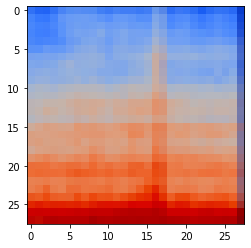

In [21]:
# Assuming you have already created a data loader called 'train_loader'
# and that it returns a batch of images and labels
images, labels = next(iter(train_dataloader))

# Take the first image from the batch
img = images[7]

# Convert the tensor to a numpy array
img = img.numpy()

# Transpose the image so that it has the format (height, width, channels)
img = np.transpose(img, (1, 2, 0))

# Plot the image
plt.imshow(img)
plt.show()

## Model Creation(CNN)

In [24]:
# Create a convolutional neural network
class EquipmentActivities(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # Create a conv layer - https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        nn.Conv2d(in_channels=input_shape, 
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # values we can set ourselves in our NN's are called hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),

        # Where did this in_features shape come from? 
        # It's because each layer of our network compresses and changes the shape of our inputs data.
        nn.Linear(in_features=hidden_units*7*7, # there's a trick to calculating this...
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x) 
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    x = torch.sigmoid(x)
    return x

## Setup device agnostic

In [25]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Create Model Instance

In [27]:
# Lets create model instance
torch.manual_seed(42)
CNN_Model = EquipmentActivities(input_shape=3,
                              hidden_units=10,
                              output_shape=len(label)).to(device)

## Check Model Summary

In [29]:
from torchsummary import summary
summary(CNN_Model, (3, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             280
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 10, 28, 28]             910
              ReLU-4           [-1, 10, 28, 28]               0
         MaxPool2d-5           [-1, 10, 14, 14]               0
            Conv2d-6           [-1, 10, 14, 14]             910
              ReLU-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 14, 14]             910
              ReLU-9           [-1, 10, 14, 14]               0
        MaxPool2d-10             [-1, 10, 7, 7]               0
          Flatten-11                  [-1, 490]               0
           Linear-12                    [-1, 2]             982
Total params: 3,992
Trainable params: 3,992
Non-trainable params: 0
-----------------------------------

## Some Helper Function

### To compute traning time

In [30]:
# Find Computational time
from timeit import default_timer as timer 
def print_train_time(start: float,
                     end: float, 
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

### To calculate accuray (Method 1)

In [31]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### To calculate accuray (Method 2)

In [32]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            predicted = (outputs > 0.5).float()  # Use threshold of 0.5 to convert probabilities to binary predictions
            total += labels.size(0) * labels.size(1)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

## Training Loop

In [33]:
## Train Loop Function

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn: accuracy_fn,
               device: torch.device=device
               ):
  """ Performs a training with model trying to learn on data_loader"""
  
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  for batch, (X, y) in enumerate(data_loader):

    # Send to the GPU
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)
    # y_pred = sigmoid(y_pred)

    # 2. Loss calculation
    loss = loss_fn(y_pred, y)
    train_loss +=loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred) # Go from logits -> pred labels
    train_accuracy = get_accuracy(model, data_loader)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss Backward
    loss.backward()

    # 5. Optimizer Step
    optimizer.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train Loss: {train_loss: .4f}  |  Train Accuracy: {train_acc: .2f}%")

## Test Loop

In [34]:
## Test Loop Function

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn: accuracy_fn,
              device: torch.device=device):
  
  # Initial loss and accuaracy
  test_loss, test_acc = 0, 0
  
  # Put the model into evaluation mode
  model.eval()

  # Open and make prediction with inference mode
  with torch.inference_mode():
    for X, y in data_loader:
      # Send data to the device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # Calculate loss and accuracy
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true = y, y_pred = test_pred) # Go from logits -> pred labels

    # Adjust average loss and accuracy
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test Loss: {test_loss: .4f}  |  Test Accuracy: {test_acc: .2f}%")

## Set loss function and optimizer

In [37]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=CNN_Model.parameters(),
                            lr=0.001)

## Train the model

In [38]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Let's define epoch numbers
epochs = 10

# Create a optimiation and evaluation loop using tran_step() and test_step()

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n----------")

  train_step(model = CNN_Model,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn)
  

  test_step(model = CNN_Model,
             data_loader = test_dataloader,
             loss_fn = loss_fn,
             accuracy_fn = accuracy_fn)
  
train_time_end_on_gpu = timer()

total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end = train_time_end_on_gpu,
                                            device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
----------
Train Loss:  1.3863  |  Train Accuracy:  0.00%
Test Loss:  1.3863  |  Test Accuracy:  0.00%
Epoch: 1
----------
Train Loss:  1.3863  |  Train Accuracy:  0.00%
Test Loss:  1.3863  |  Test Accuracy:  0.00%
Epoch: 2
----------
Train Loss:  1.3863  |  Train Accuracy:  0.00%
Test Loss:  1.3863  |  Test Accuracy:  0.00%
Epoch: 3
----------
Train Loss:  1.3863  |  Train Accuracy:  0.00%
Test Loss:  1.3863  |  Test Accuracy:  0.00%
Epoch: 4
----------
Train Loss:  1.3863  |  Train Accuracy:  0.00%
Test Loss:  1.3863  |  Test Accuracy:  0.00%
Epoch: 5
----------
Train Loss:  1.3863  |  Train Accuracy:  0.00%
Test Loss:  1.3863  |  Test Accuracy:  0.00%
Epoch: 6
----------
Train Loss:  1.3863  |  Train Accuracy:  0.00%
Test Loss:  1.3863  |  Test Accuracy:  0.00%
Epoch: 7
----------
Train Loss:  1.3863  |  Train Accuracy:  0.00%
Test Loss:  1.3863  |  Test Accuracy:  0.00%
Epoch: 8
----------
Train Loss:  1.3863  |  Train Accuracy:  0.00%
Test Loss:  1.3863  |  Test Accuracy: